# Question 1

In [6]:
DEBUG = True # Set to False to disable debugging or exessive output for submission

In [7]:
#TODO: Take 10%, do our experiment, and then take 80% to train and use the other 10% to test.
#TODO: Pearsons R score for deciding what to use.



## Importing the required libraries

The following libraries are required to solve the problem. This code installs the required libraries if they are not already installed.

In [8]:
%pip install pandas -q
%pip install numpy -q
%pip install matplotlib -q
%pip install seaborn -q
%pip install scikit-learn -q
%pip install scipy -q
%pip install deap -q
%pip install pytorch -q
%pip install tqdm -q


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
  error: subprocess-exited-with-error
  
  × Building wheel for pytorch (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [17 lines of output]
      Traceback (most recent call last):
        File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py

The libraries are then imported.

In [9]:
import math
import random
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from deap import base, creator, tools 
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from torch import nn
import torch 
import concurrent.futures


/var/folders/01/z8y87srs6v7g5h7dy9fw6_kr0000gn/T/ipykernel_44449/2733749496.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In order to ensure that the results are reproducible, the random seed is set to 42 in both the random and numpy libraries.

In [10]:
random.seed(42)
np.random.seed(42)

## Data Import & Cleaning

In this section, we will load the data and perform some basic analysis to understand the data better.
This is an important step as it helps us understand the data better and also helps us in identifying any data quality issues that need to be addressed.


In [11]:
all_data = pd.read_csv('eScooterDemand.csv')

Splitting the date into Month, Year and Day means that we can use them as features seperately. This means that we can use the day of the week and month of the year as features in our model, irrespective of the year. This is important as the day of the week and month of the year can have an impact on the number of rentals. It also improves the reusability of the model as we can use the same model for future years.

This adds the following columns to the dataframe:
- Month
- Year
- Day
- Weekday (0 = Monday, 6 = Sunday)
- Weekend (1 = Weekend, 0 = Weekday)


In [12]:
all_data['Date'] = pd.to_datetime(all_data['Date'], format='%d/%m/%Y')
all_data['Month'] = all_data['Date'].dt.month.astype('int64')
all_data['Year'] = all_data['Date'].dt.year.astype('int64')
all_data['Day'] = all_data['Date'].dt.day.astype('int64')
all_data['Weekday'] = all_data['Date'].dt.weekday.astype('int64')
all_data['Weekend'] = all_data['Date'].dt.dayofweek.map(lambda x: 1 if x > 4 else 0).astype('int64')
all_data.drop(columns='Date', inplace=True)

We also change the data type of the following columns from strings to integers so that we can use them in our model:

In [13]:
all_data['HireAvailable'] = all_data['HireAvailable'].map({'Yes': 1, 'No': 0}).astype('int64')
all_data['Public Holiday'] = all_data['Public Holiday'].map({'Yes': 1, 'No': 0}).astype('int64')
all_data['Season'] = all_data['Season'].map({'Spring': 0, 'Summer': 1, 'Autumn': 2, 'Winter': 3}).astype('int64')

This is an example of the data after the adjustments:

In [14]:
all_data.sample(5)

,Count,Hour,Temp,Humidity,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Season,Public Holiday,HireAvailable,Month,Year,Day,Weekday,Weekend
6056,1728,8,27.2,69,1.8,1999,21.0,0.70,0.0,0.0,1,0,1,8,2018,10,4,0
5556,822,12,32.6,51,2.1,800,21.1,3.21,0.0,0.0,1,0,1,7,2018,20,4,0
5990,658,14,34.0,50,1.2,1744,22.1,1.68,0.0,0.0,1,0,1,8,2018,7,1,0
7674,2716,18,16.9,47,1.4,1637,5.5,0.11,0.0,0.0,2,0,1,10,2018,16,1,0
3319,1083,7,6.4,51,1.0,1398,-3.0,0.19,0.0,0.0,0,0,1,4,2018,18,2,0


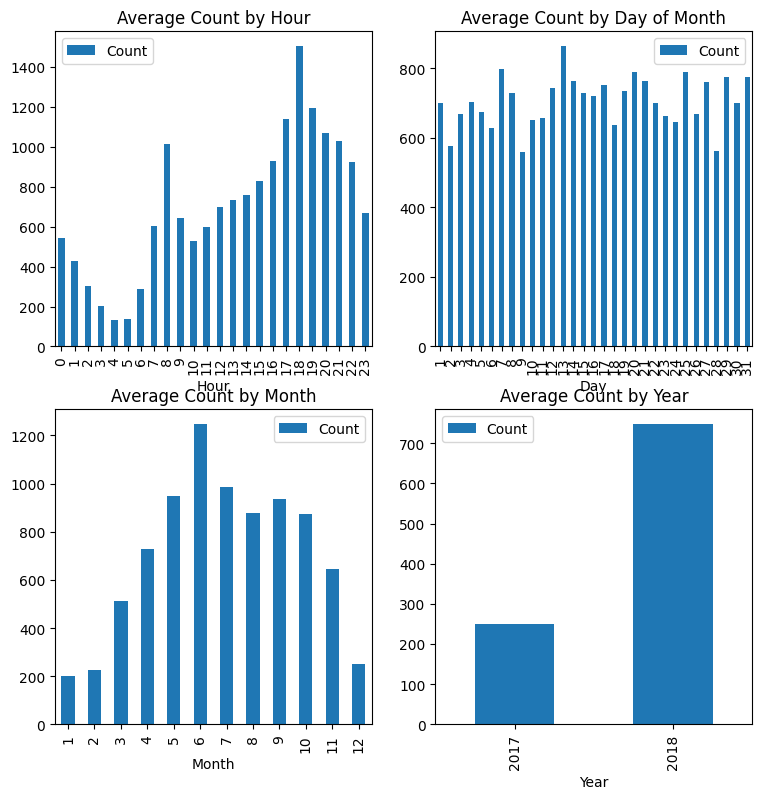

In [15]:
## Show all plots on one figure
fig, ax = plt.subplots(2, 2, figsize=(9, 9))
all_data.groupby('Hour').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 0], title='Average Count by Hour')
all_data.groupby('Day').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[0, 1], title='Average Count by Day of Month')
all_data.groupby('Month').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 0], title='Average Count by Month')
all_data.groupby('Year').aggregate({'Count': 'mean'}).plot(kind='bar', ax=ax[1, 1], title='Average Count by Year')

plt.show()


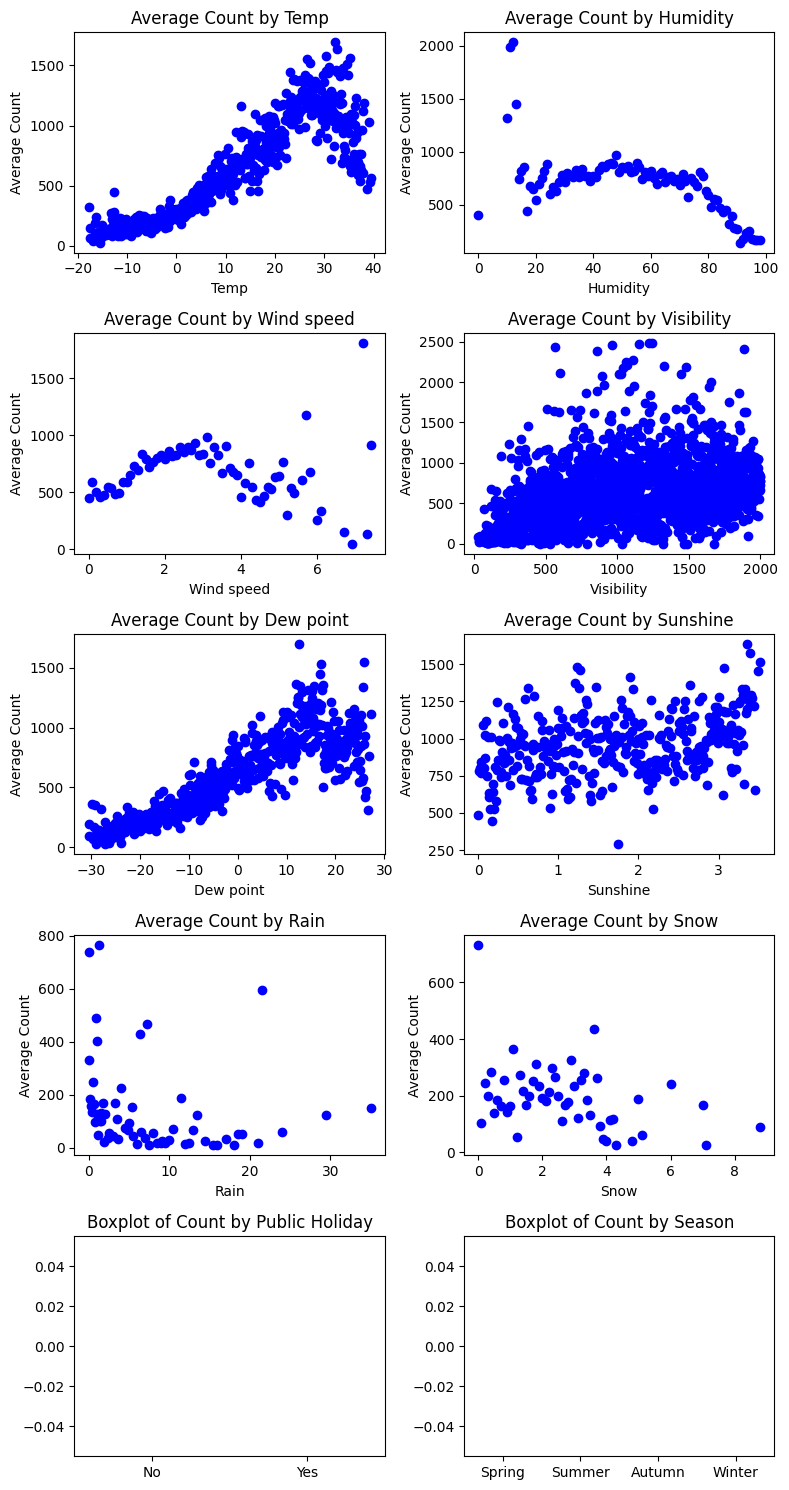

In [16]:

columns_to_plot = ['Temp', 'Humidity', 'Wind speed', 'Visibility', 'Dew point', 'Sunshine', 'Rain', 'Snow']

fig, ax = plt.subplots(5, 2, figsize=(8, 15))

ax = ax.flatten()

# Plot each column against the count of rentals
for i, col in enumerate(columns_to_plot):
    # Group data by the current column and calculate average count of rentals
    average_rental_counts = all_data.groupby(col)['Count'].mean().reset_index()
    
    # Plot the data
    ax[i].scatter(average_rental_counts[col], average_rental_counts['Count'], color='blue')
    ax[i].set_title(f'Average Count by {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel('Average Count')

# Plot boxplot for season in the last subplot
seasons = ['Spring', 'Summer', 'Autumn', 'Winter']
boxplot_data = [all_data[all_data['Season'] == season]['Count'] for season in seasons]
ax[-1].boxplot(boxplot_data, labels=seasons, showfliers=False)
ax[-1].set_title('Boxplot of Count by Season')

# boxplot for public holiday
public_holidays = ['No', 'Yes']
boxplot_data = [all_data[all_data['Public Holiday'] == holiday]['Count'] for holiday in public_holidays]
ax[-2].boxplot(boxplot_data, labels=public_holidays, showfliers=False)
ax[-2].set_title('Boxplot of Count by Public Holiday')

plt.tight_layout()

plt.show()

From this we can see that there is a clear causation between the number of scooters hired and the temperature, humidity, sunshine, windspeed and dew point as they show a gradient or bell curve in the diagrams. There is also a pattern to the average count relation to snow and rain.
We can also see a difference in means and ranges in the different seasons.
However, it is hard to tell for some of them, such as visibility, so we will calculate the pearson r score for each to examine the correlation.


In [17]:

p_values = {}

for column in all_data.columns:
    if column == 'Count':
        continue 
    if all_data[column].dtype in ['int64', 'float64']:  # Check if the column contains numeric data
        correlation_coefficient, p_value = pearsonr(all_data[column], all_data['Count'])
        p_values[column] = {'p_value': p_value, 'significant': p_value < 0.01}
    else:
        p_values[column] = {'p_value': None, 'significant': False}

# Convert dictionary to DataFrame for better visualization
p_values_df = pd.DataFrame.from_dict(p_values, orient='index', columns=['p_value', 'significant'])

# Sort DataFrame by p-value in ascending order
p_values_df = p_values_df.sort_values(by='p_value')

display(p_values_df)
feature_list = p_values_df.query('significant').index.tolist()



,p_value,significant
Hour,0.000000e+00,True
Temp,0.000000e+00,True
Dew point,1.325584e-298,True
Season,5.268073e-178,True
Sunshine,2.780395e-137,True
Year,2.830579e-92,True
HireAvailable,6.732211e-83,True
Humidity,1.475065e-79,True
Visibility,3.672704e-79,True
Snow,1.398012e-40,True


From the R2 scores, if we are using significance of < 0.01 then we can see that all the data points are statistically signigicant other than Day. Therefore we will drop day.

In [18]:
all_data = all_data.drop(columns=['Day']) 

## Data normalization
In order to normalize the data we will use the MinMaxScaler from sklearn.preprocessing. This will scale the data to be between 0 and 1. This is important as the data is on different scales and we want to make sure that the model is not biased towards the larger values or smaller. We are only scaling the numerical data rather than the catagorical data such as HireAvailable and Month. We are also not scaling the target variable as we want to be able to interpret the results in terms of the original data.
Lastly we are scaling the year data as it is a numerical value and we want to make sure that it is closer to being on the same scale as the other numerical data.

In [19]:
from sklearn import preprocessing

features = ['Temp',
'Wind speed',
'Visibility',
'Dew point',
'Sunshine',
'Rain',
'Snow',
'Humidity'
]


display(all_data[features].describe())
normalised_data = all_data.copy()

# for feature in features:
scaler = preprocessing.MinMaxScaler((-1, 1))
# Fit the scaler to your data
scaler.fit(normalised_data[features])

# Transform the selected features
normalised_data[features] = scaler.transform(normalised_data[features])

normalised_data['Year'] = (normalised_data['Year'] - 2018)/10
normalised_data['Month'] = normalised_data['Month']/12




,Temp,Wind speed,Visibility,Dew point,Sunshine,Rain,Snow,Humidity
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,12.882922,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068,58.226256
std,11.944825,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746,20.362413
min,-17.800000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000,42.000000
50%,13.700000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000,57.000000
75%,22.500000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000,74.000000
max,39.400000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000,98.000000


To show the difference between the normalised and non-normalised data, we can crete box plots of the data before and after normalisation. This will show the difference in the scales of the data.

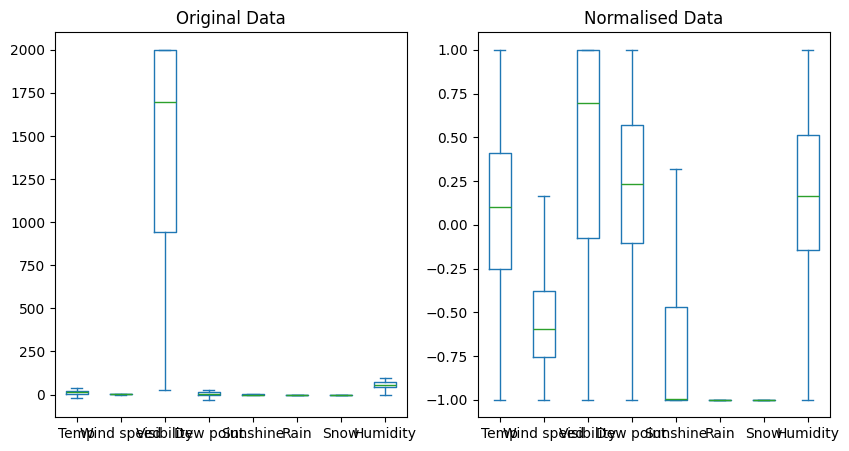

In [20]:
## visualise on boxplot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
all_data[features].plot(kind='box', ax=ax[0], title='Original Data', showfliers=False)
normalised_data[features].plot(kind='box', ax=ax[1], title='Normalised Data', showfliers=False)
plt.show()


## Model
I will be using a multilayer perceptron with 2 hidden layers for my model. 
This is because I wanted to use a model that is capable of capturing complex patterns in the data. The more layers that a model has, the more complex patterns it can capture. This is important as the relationship between the features and the target is not linear and a simple model like linear regression would not be able to capture this relationship.

I tried using a larger number of layers but found that the time for training the model was too long. I also tried using a smaller number of layers but found that the model was not able to capture the relationship between the features and the target well enough.

This was chosen instead of genetic programming because it meant that I could use a model that I was more familiar with, and also I could compare the results to a version trained with backpropagation.



### The MLP Class
The MLP class is a simple class that creates a multilayer perceptron model with 2 hidden layers. The model is created using the Sequential class from the pytorch library. I ensure that the gradients are frozen to allow for faster training.

The model has 2 hidden layers, the number of neurons in each layer is specified by the hidden_size parameters. The activation function used in each layer is the ReLU activation function. The output layer always has a single neuron as we are predicting a single value but the hidden layer sizes are decided using a gridsearch later on. 

The ReLU activation function is used in the hidden layers as it is known to work well with deep neural networks. The output layer has no activation function as we are predicting a continuous value and we do not want to restrict the output to a specific range.

We will be evolving the weights of the model in order to improve the performance of it, rather than using back propogation. Therefore we need to set up the functions for setting the weights and retrieving the weights.


In [21]:
torch.set_grad_enabled(False)

class MLP(nn.Module):
    @torch.no_grad
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLP, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

    @torch.no_grad
    def forward(self, x):
        x = torch.tensor(x).float()
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def set_weights_linear(self, weights):
        weights = torch.tensor(weights)
        start_idx = 0
        end_idx = self.input_size * self.hidden_size
        self.fc1.weight.data = weights[start_idx:end_idx].reshape(self.hidden_size, self.input_size)
        start_idx = end_idx
        end_idx += self.hidden_size
        self.fc1.bias.data = weights[start_idx:end_idx]

        start_idx = end_idx
        end_idx += self.hidden_size * self.hidden_size2
        self.fc2.weight.data = weights[start_idx:end_idx].reshape(self.hidden_size2, self.hidden_size)
        start_idx = end_idx
        end_idx += self.hidden_size2
        self.fc2.bias.data = weights[start_idx:end_idx]

        start_idx = end_idx
        end_idx += self.hidden_size2 * self.output_size
        self.fc3.weight.data = weights[start_idx:end_idx].reshape(self.output_size, self.hidden_size2)
        start_idx = end_idx
        self.fc3.bias.data = weights[start_idx:]

    def get_weights(self):
  
        return torch.cat([self.fc1.weight.data.view(-1), self.fc1.bias.data, self.fc2.weight.data.view(-1), self.fc2.bias.data, self.fc3.weight.data.view(-1), self.fc3.bias.data])
    


## Setup for Genetic Programming

This section sets up the functions that are required for genetic programming. This includes the functions for creating the initial population, selecting parents, crossover, mutation and evaluation. I then explain my choices after the code.

In [22]:
def setup(ind_size, eval_function, fitness_weights, init_min = -1, init_max = 1, mu = 0.0, sigma = 0.5, indpb = 0.4):
    """Set up the DEAP toolbox.

    Args:
        ind_size (int): The size of the individuals to create
        eval_function (function): The evaluation function to use
        fitness_weights (tuple): The weights for the fitness function
        init_min (float): The minimum value for the initialisation of genes
        init_max (float): The maximum value for the initialisation of genes

    Returns:
        toolbox: The DEAP toolbox
    """

    # During the grid search, the creator warns if functions are overwritten, so we just delete them
    try:
      del creator.FitnessMax
      del creator.Individual
    except Exception as e: 
      pass
      
    # Create the DEAP creator for an individual
    creator.create("FitnessMax", base.Fitness, weights=fitness_weights)
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Create the DEAP toolbox
    toolbox = base.Toolbox()

    # Register the fitness function
    toolbox.register("evaluate", eval_function)

    # Create the individual
    toolbox.register("attr_float", random.uniform, init_min, init_max)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                     toolbox.attr_float, n=ind_size)
    
    toolbox.register("select", tools.selTournament, tournsize=3)

    toolbox.register("mutate", tools.mutGaussian, mu=mu, sigma=sigma, indpb=indpb) 

    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    return toolbox

### Individuals 
Each individual in the population is a list of weights for the model. The weights are flattened into a single list so that they can be easily manipulated. The length of the list is equal to the total number of weights in the model. 
The individuals use lists of floats to represent the weights as these can easily be manipulated using the genetic operators. They can also be easily converted to tensors when evaluating the model.

### Initial Population
The initial population is created by generating a random list of weights for each individual in the population. The weights are generated using random numbers between a specified range. The values for the range defaults to -1 and 1 but a grid search will be used to find the best range.

### Selection
The selection function is the function that decides on the parent individuals that get used to generate the next individuals. The selection function uses the tournament selection method. The implementation is build into the DEAP library. The tournament selection method works by selecting a number of random individuals from the population and then selecting the best individual from that subset. This process is repeated until the required number of parents have been selected. I use a tournament size of 3 as this is a common value for this parameter. It allows for a good balance between exploration and time.

### Crossover
Cross over is not used in this model because the performance of the model will likely be degraded by doing so. This is because the weights of the model are not independent of each other and changing one weight can have a large impact on the performance of the model. Therefore, it is better to use mutation to change the weights of the model.

### Mutation
The mutation function used in this model is a Guassian Mutation function. It allows for the weights of the model to be mutated by adding a random value to each weight. The random value is generated using a normal distribution with a mean and a standard deviation. This means that the weights are changed by a small amount each time they are mutated. This is important as it allows the model to explore the search space more effectively. The mean and standard deviation are hyperparameters that can be tuned using a grid search. The function also takes an indpb parameter which is the probability that a weight will be mutated. This is also a hyperparameter that can be tuned using a grid search.

### Evaluation Function
When evaluating the model, we use an evaluation function. I tested 3 main evaluation functions when creating the model. The first was to use the mean squared error as the evaluation function. This is a common evaluation function for regression problems as it measures the average squared difference between the predicted and actual values. The second evaluation function I tested was the mean absolute error. This is similar to the mean squared error but it measures the average absolute difference between the predicted and actual values. The third evaluation function I tested was the R2 score. This is a common evaluation function for regression problems as it measures the proportion of the variance in the target variable that is predictable from the features. 
I found that the 

In [23]:
import time
def timing_val(func):
    def wrapper(*arg, **kw):
        '''source: http://www.daniweb.com/code/snippet368.html'''
        t1 = time.time()
        res = func(*arg, **kw)
        return (t2 - t1), res, func.__name__
    return wrapper

In [24]:
def eval_R2(individual, myNet, evdata, feature_list):
    """Evaluate the fitness of the individual for the MLP

    Args:
        individual (list): The individual to evaluate               
        mlp (MLP): The MLP to evaluate
        X (np.ndarray): The input data
        y (np.ndarray): The output data

    Returns:
        tuple: The fitness of the individual,
    """
    myNet.set_weights_linear(individual)
    y_pred = [myNet.forward([evdata[f][i] for f in feature_list], False) for i in range(len(evdata))] 
    fitness = r2_score(evdata["Count"].to_list(), y_pred)
    return fitness,

def eval_MSE(individual, myNet, evdata, feature_list):
  myNet.set_weights_linear(individual)
  fitness = 0

  input_data = evdata[feature_list].values
  target_data = evdata['Count'].values

  with torch.no_grad():
    for i in range(len(evdata)):
      output = myNet.forward(input_data[i])
      fitness += (target_data[i] - output[0])**2

  return fitness/len(evdata),

def eval_MAE(individual, myNet, evdata, feature_list):
  myNet.set_weights_linear(individual)
  fitness = 0
  preds = []
  for i in range(len(evdata)):
    # use feature_list to get the correct columns
    input = [evdata[f][i] for f in feature_list]
    output = myNet.forward(input)
    preds.append(output)
    fitness += abs(evdata['Count'][i] - output[0])

  return fitness/len(evdata),

In [25]:
  # Set up the size of the individual based on the number of weights and biases
  NUM_WEIGHTS = (len(feature_list) * 2) + (2 * 2) + (2 * 1)
  NUM_BIASES = 2 + 2 + 1

  IND_SIZE = NUM_WEIGHTS + NUM_BIASES

In [26]:
feature_list

['Hour',
 'Temp',
 'Dew point',
 'Season',
 'Sunshine',
 'Year',
 'HireAvailable',
 'Humidity',
 'Visibility',
 'Snow',
 'Month',
 'Rain',
 'Wind speed',
 'Public Holiday',
 'Weekend',
 'Weekday']

In [27]:
IND_SIZE

43

In [28]:
eval_MSE([1.0 for i in range(43)], MLP(len(feature_list), 2, 2, 1), normalised_data, feature_list)

(tensor(804840.5000),)

# Investigation of parameters and representation

There are a number of things we need to investigate and find the best of
- Evaluation function (MAE, MSE, R2)
- Model architecture (number of neurons in each layer)
- Mutation parameters (mean, sigma, indpb)
- Initialisation values for min and max weights


## Splitting the data

The first thing that we need to do is split the data into testing and training sets. This is so that we can test the model on data it has not been fit to estimate. This allows us to evaluate the usefulness of the model. 

We will use 80% of the data for training and 20% for testing. This is a common split for this type of problem. From the training data we will also take a 10% subset to use for hyperparamater tuning. This is so that we can speed up the hyperparameter tuning process.


In [29]:
test_data = normalised_data.sample(frac=0.2, random_state=42)
train_data = normalised_data.drop(test_data.index)

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

tuning_data = train_data.sample(frac=0.1).reset_index(drop=True)

## Training Set up 

This function is a simple function that sets up the training process for the genetic algorithm. It takes the following parameters:
- feature_list: A list of the features that will be used to train the model
- training_data: The training data that will be used to evolve the model
- hidden_nodes_1: The number of nodes in the first hidden layer
- hidden_nodes_2: The number of nodes in the second hidden layer
- evaluation_function: The evaluation function that will be used to evaluate the model
- fitness weights: The weights that will be used to calculate the fitness of the model
- init_min: The minimum value that the initial weights can take (defaults to -1)
- init_max: The maximum value that the initial weights can take (defaults to 1)
- mu: The mean of the normal distribution used mutGaussian mutation (defaults to 0)
- sigma: The standard deviation of the normal distribution used for mutation (defaults to 0.5)
- indpb: The probability that a weight will be mutated (defaults to 0.05)
- ngen: The number of generations that the genetic algorithm will run for (defaults to 100)
- pop_size: The size of the population (defaults to 200)

This was done in a seperate function so that I can reduce the repetition of my code when doing grid searches and evaluations.

In [33]:
from datetime import datetime
def training(feature_list, training_data, hidden_nodes_1, hidden_nodes_2, evaluation_function, fitness_weights = (-1.0,), init_min = -1, init_max = 1, mu = 0.0, sigma = 0.5 , indpb = 0.5, NGEN=100, pop_size = 200):
  num_input_nodes = len(feature_list)
  num_output_nodes = 1

  # Set up the size of the individual based on the number of weights and biases
  NUM_WEIGHTS = (num_input_nodes * hidden_nodes_1) + (hidden_nodes_1 * hidden_nodes_2) + (hidden_nodes_2 * num_output_nodes)
  NUM_BIASES = hidden_nodes_1 + hidden_nodes_2 + num_output_nodes

  IND_SIZE = NUM_WEIGHTS + NUM_BIASES

  # Sets up the DEAP toolbox
  toolbox = setup(IND_SIZE, evaluation_function, fitness_weights, init_min, init_max, mu, sigma, indpb)

  myNet = MLP(num_input_nodes, hidden_nodes_1, hidden_nodes_2, num_output_nodes) 

  # Set up logbook and hall of fame for recording statistics during evolution
  logbook = tools.Logbook()
  hof = tools.HallOfFame(1)
  pop = toolbox.population(n=pop_size)

  # Evaluate the entire population before starting the evolution
  fitnesses = [toolbox.evaluate(indiv, myNet, training_data, feature_list) for indiv in pop]
  for ind, fit in zip(pop, fitnesses):
      ind.fitness.values = fit

  # Set up statistics to record during evolution
  stats = tools.Statistics(key=lambda ind: ind.fitness.values)
  stats.register("avg", np.mean)
  stats.register("std", np.std)
  stats.register("min", np.min)
  stats.register("max", np.max)

  ### EVOLUTION LOOP ###

  for g in range(NGEN):
      if DEBUG:
        print("-- Generation %i --" % g)
        print(datetime.now())
      
      # Select the next generation individuals using tournament selection
      offspring = toolbox.select(pop, len(pop))
      offspring = list(map(toolbox.clone, offspring))

      # Apply crossover and mutation on the offspring then delete the fitness value of the modified individuals.
      for mutant in offspring:
          toolbox.mutate(mutant)
          del mutant.fitness.values

      # Evaluate the individuals with an invalid fitness value, ie, the ones that were modified and assign a fitness value to them.         
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      for ind in invalid_ind:
          ind.fitness.values = toolbox.evaluate(ind, myNet, training_data, feature_list)

      # Replace the current population by the offspring
      pop[:] = offspring
      record = stats.compile(pop)
      logbook.record(gen=g, **record)


      hof.update(pop)

      if g%5==0 and DEBUG:
        print(record)
  
  best_ind = hof[0]

  return best_ind, logbook

In [34]:
def get_generation_with_best_fitness(logbook, fitness_type):
    if fitness_type == 'R2':
        best_index = max(range(len(logbook)), key=lambda i: logbook[i]['max'])
        print(f"Best index: {best_index}")
    else:
        best_index = min(range(len(logbook)), key=lambda i: logbook[i]['min'])

    generations = [entry['gen'] for entry in logbook]
    
    # Return the generation with the best individual
    return generations[best_index]


In [35]:
# grid search hidden nodes
hidden_nodes_1_list = [16, 24, 32, 64]
hidden_nodes_2_list = [16, 24, 32, 64]
results = []
tuning_data = train_data.sample(frac=0.1).reset_index(drop=True)
evaluation_functions = [(eval_MSE,(-1.0, )), (eval_R2, (1.0,)),  (eval_MAE, (-1.0,))]
for evaluation_function, weights in evaluation_functions:
  for hidden_nodes_1 in hidden_nodes_1_list:
    for hidden_nodes_2 in hidden_nodes_2_list:
      print(f"Training with {hidden_nodes_1} and {hidden_nodes_2} hidden nodes")

      best_ind, logbook = training(feature_list, train_data, hidden_nodes_1, hidden_nodes_2, evaluation_function, weights, NGEN=50, pop_size=100)

      myNet = MLP(len(feature_list), hidden_nodes_1, hidden_nodes_2, 1)
      myNet.set_weights_linear(best_ind)

      x_values1 = test_data['Temp'].to_list()
      y_values1 = test_data['Count'].to_list()

      x_values2 = test_data['Temp'].to_list()
      y_values2 = [myNet.forward([test_data[f][i] for f in feature_list]) for i in range(len(test_data))] 

      results.append({'hidden_nodes_1': hidden_nodes_1, 'hidden_nodes_2': hidden_nodes_2, 'evaluation_function': evaluation_function.__name__, 'r2': r2_score(y_values1, y_values2), "logbook": logbook}) 
      if DEBUG:
        print(f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}")


Training with 16 and 16 hidden nodes
-- Generation 0 --
2024-05-15 21:44:30.909372


Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'eval_MSE' on <module '__main__' (built-in)>
Process SpawnPoolWorker-15:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Vers

KeyboardInterrupt: 

In [ ]:
results_df = pd.DataFrame(results, columns=['hidden_nodes_1', 'hidden_nodes_2', 'evaluation_function', 'r2', 'logbook']).sort_values(by='r2', ascending=False).reset_index(drop=True)
results_df['Best Generation'] = results_df.apply(lambda x: get_generation_with_best_fitness(x['logbook'], x['evaluation_function']), axis=1)
display(results_df[["hidden_nodes_1", "hidden_nodes_2", "r2", "Best Generation"]])



,hidden_nodes_1,hidden_nodes_2,r2,Best Generation
0,24,24,0.404261,40
1,16,24,0.394999,38
2,16,64,0.386819,44
3,32,24,0.381666,27
4,16,16,0.380959,46
5,24,16,0.380608,47
6,32,32,0.379098,34
7,24,32,0.378470,48
8,32,16,0.363961,44
9,24,64,0.362683,24


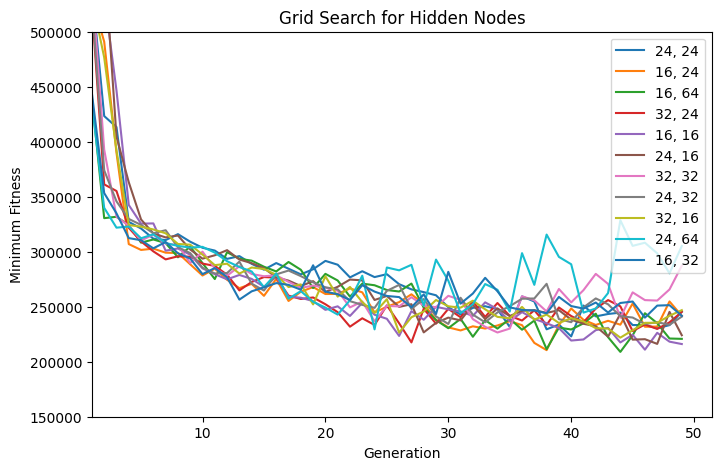

In [ ]:
## Plot grid search
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, result in results_df.iterrows():
    # print(result.get('logbook'))
    ax.plot(result['logbook'].select('gen'), result['logbook'].select('min'), label=f'{result["hidden_nodes_1"]}, {result["hidden_nodes_2"]}')
ax.set_xlabel('Generation')
ax.set_ylabel('Minimum Fitness')
ax.set_title('Grid Search for Hidden Nodes')
ax.set_xbound(1)
ax.set_ybound(150000, 500000)
ax.legend()
plt.show()


The results of this grid search show that the following parameters are the best for the model which are the ones we will proceed with:

In [ ]:
display(results_df[["hidden_nodes_1", "hidden_nodes_2", "evaluation_function"]][:1])

,hidden_nodes_1,hidden_nodes_2,evaluation_function
0,24,24,eval_MSE


Note: I am acknowledging that this may not be the best representation of which is the optimal parameters, but it is the best that I can do with the time and resources that I have available to me.

Another part of the investigation is to find the best inpdbs for the model. This is the probability of mutation for each attribute of an individual. We will be testing the values of 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 and 1.0. We will be using the best parameters from the previous grid search to find the best indpb value.

In [ ]:
indpbs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results_indpb = []

tuning_data = train_data.sample(frac=0.1).reset_index(drop=True)

for indpb in indpbs:
      print(f"Training with 24 and 24 hidden nodes")
      with torch.no_grad():
        best_ind, logbook = training(feature_list, tuning_data, 16, 16, eval_MSE, (-1.0, ), indpb=indpb, NGEN=200, pop_size=100)

        myNet = MLP(len(feature_list), 16, 16, 1)
        myNet.set_weights_linear(best_ind)

        x_values1 = test_data['Temp'].to_list()
        y_values1 = test_data['Count'].to_list()

        x_values2 = test_data['Temp'].to_list()
        y_values2 = [myNet.forward([test_data[f][i] for f in feature_list]) for i in range(len(test_data))] 

      results_indpb.append({'indpb': indpb,'r2': r2_score(y_values1, y_values2), "logbook": logbook}) 
      if DEBUG:
        print(f"R2 Score: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}")


Training with 24 and 24 hidden nodes
-- Generation 0 --
{'avg': 847065.4, 'std': 24089.58, 'min': 788383.1, 'max': 894361.56}
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
-- Generation 5 --
{'avg': 735606.06, 'std': 36207.684, 'min': 655832.2, 'max': 810406.25}
-- Generation 6 --
-- Generation 7 --
-- Generation 8 --
-- Generation 9 --
-- Generation 10 --
{'avg': 562260.4, 'std': 48183.27, 'min': 439128.0, 'max': 680209.9}
-- Generation 11 --
-- Generation 12 --
-- Generation 13 --
-- Generation 14 --
-- Generation 15 --
{'avg': 409279.53, 'std': 27918.28, 'min': 363201.72, 'max': 486020.06}
-- Generation 16 --
-- Generation 17 --
-- Generation 18 --
-- Generation 19 --
-- Generation 20 --
{'avg': 363604.12, 'std': 9946.603, 'min': 346722.3, 'max': 417078.28}
-- Generation 21 --
-- Generation 22 --
-- Generation 23 --
-- Generation 24 --
-- Generation 25 --
{'avg': 351980.47, 'std': 13316.8, 'min': 338103.25, 'max': 435574.47}
-- Generation 26 --
-- Gener

AttributeError: 'MLP' object has no attribute 'feed_forward'

In [ ]:
display(pd.DataFrame(results_indpb, columns=['indpb', 'r2']).sort_values(by='r2', ascending=False).reset_index(drop=True))

,indpb,r2
0,0.1,0.508286
1,0.2,0.496978
2,0.6,0.444376
3,0.3,0.425442
4,0.5,0.416436
5,0.4,0.410731
6,0.7,0.390821
7,0.8,0.350003
8,0.9,0.332885


In [ ]:
## Grid search for mu 

# grid search hidden nodes
mu_options = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

results = []
tuning_data = train_data.sample(frac=0.1).reset_index(drop=True)

for mu in mu_options:
  print(f"Training with {mu} hidden nodes")

  best_ind, logbook = training(feature_list, tuning_data, 24, 24, eval_MSE, (-1.0, ), mu = mu, NGEN=200, pop_size=100)

  myNet = MLP(len(feature_list), 24, 24, 1)
  myNet.set_weights_linear(best_ind)

  y_values1 = test_data['Count'].to_list()

  y_values2 = [myNet.forward([test_data[f][i] for f in feature_list]) for i in range(len(test_data))] 

  results.append({'mu':mu, 'r2': r2_score(y_values1, y_values2), "logbook": logbook}) 
  if DEBUG:
    print(f"R2: {r2_score(y_values1, y_values2)}, Min fitness: {min(logbook.select('min'))}")


Training with 0.0 hidden nodes
R2: 0.3411572305574536, Min fitness: 255969.09375
Training with 0.01 hidden nodes
R2: 0.3411572305574536, Min fitness: 255969.09375
Training with 0.02 hidden nodes
R2: 0.3411572305574536, Min fitness: 255969.09375
Training with 0.03 hidden nodes
R2: 0.3411572305574536, Min fitness: 255969.09375
Training with 0.04 hidden nodes
R2: 0.3411572305574536, Min fitness: 255969.09375
Training with 0.05 hidden nodes
R2: 0.3411572305574536, Min fitness: 255969.09375


In [ ]:
display(pd.DataFrame(results, columns=['mu', 'r2']).sort_values(by='r2', ascending=False).reset_index(drop=True))

,mu,r2
0,0.05,-0.090922
1,0.02,-0.385855
2,0.00,-0.629418
3,0.04,-0.715192
4,0.01,-1.964428
5,0.03,-25.298640


## Final Model

## Evaluating Results